### WordNet 맛보기

In [1]:
! pip install nltk

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wousi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from nltk.corpus import wordnet

In [4]:
wordnet.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

In [5]:
car = wordnet.synset('car.n.01')
car.definition()

'a motor vehicle with four wheels; usually propelled by an internal combustion engine'

In [6]:
car.lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

In [7]:
# 상위어 
# 다른단어와의 의미적 상하관계
car.hypernym_paths()[0] 

[Synset('entity.n.01'),
 Synset('physical_entity.n.01'),
 Synset('object.n.01'),
 Synset('whole.n.02'),
 Synset('artifact.n.01'),
 Synset('instrumentality.n.03'),
 Synset('container.n.01'),
 Synset('wheeled_vehicle.n.01'),
 Synset('self-propelled_vehicle.n.01'),
 Synset('motor_vehicle.n.01'),
 Synset('car.n.01')]

In [8]:
car = wordnet.synset('car.n.01')
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')
car.path_similarity(novel)

0.05555555555555555

In [9]:
car.path_similarity(dog)

0.07692307692307693

In [10]:
car.path_similarity(motorcycle)

0.3333333333333333

## 2.3 통계 기반 기법

In [11]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.',' .')
text

'you say goodbye and i say hello .'

In [12]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [13]:
word_to_id = {}
id_to_word = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [14]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [15]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [16]:
id_to_word[1]

'say'

In [17]:
word_to_id['hello']

5

In [18]:
import numpy as np 
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [19]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    word_to_id ={}
    id_to_word ={}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w]] for w in words)
    return corpus, word_to_id, id_to_word

In [20]:
text = 'You say goodbye and I say hello.'
corpus , word_to_id, id_to_word = preprocess(text)

## 2.3.2. 단어의 분산표현(distributional representation)
- 분포가설: 단어의 의미는 주변단어에 의해 형성된다. 
- 단어자체에는 의미가 없고, 그 단어가 사용된 맥락(context)이 의미를 형성한다는 것.
- 맥락: 주변에 놓인 단어를 가르킨다. 

In [21]:
# 동시발생 행렬
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus , word_to_id, id_to_word = preprocess(text)

In [22]:
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [23]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size,vocab_size),dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx = idx-i
            right_idx = idx+i
            if left_idx>=0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id,left_word_id] +=1
            if right_idx<corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix 

In [24]:
create_co_matrix(corpus,8)

array([[0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
def cos_similarity(x,y,eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx,ny)

In [26]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  # "you"의 단어 벡터
c1 = C[word_to_id['i']]    # "i"의 단어 벡터
print(c0)
print(c1)
print(cos_similarity(c0, c1))

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799


In [27]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [28]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4. 통계기반 기법 개선하기 

## 2.4.1. 상호정보량

In [29]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [30]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)


동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


## 2.4.3. SVD에 의한 차원 감소

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.664e-16]
word: you word_id: 0
word: say word_id: 1
word: goodbye word_id: 2
word: and word_id: 3
word: i word_id: 4
word: hello word_id: 5
word: . word_id: 6


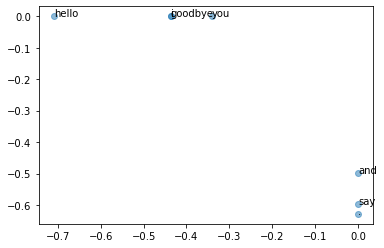

In [31]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print(C[0])
print(W[0])
print(U[0])

# 플롯
for word, word_id in word_to_id.items():
    print('word:',word,'  word_id:', word_id)
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


## 2.4.4 PTB데이터셋

In [1]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


## 2.4.5. PTB 데이터셋 평가

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
    print(U.shape, S.shape,V.shape)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)
    print(U.shape, S.shape,V.shape)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


동시발생 수 계산 ...
PPMI 계산 ...


C:\Users\wousi\OneDrive\AIFFEL_After\DLFS2\code\common\util.py:141: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\wousi\OneDrive\AIFFEL_After\DLFS2\code\common\util.py:141: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...
(10000, 100) (100,) (100, 10000)

[query] you
 i: 0.7218613028526306
 we: 0.6086142063140869
 some